Import packages.

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error
from gluonts.evaluation.metrics import smape
from tqdm import tqdm

Specify a dataset and load its cross-validation forecasts.

In [12]:
# name = "m4_hourly"
name = "ett1/15T"
term = "short"

results_dir = Path("../results")
all_files = list(results_dir.rglob("cross_validation.csv"))

kwargs = {
    "desc": "Reading cross-validation files",
    "total": len(all_files),
    "unit": "files",
    "disable": False,
}

for file in tqdm(all_files, **kwargs):
    if name in str(file) and term in str(file):
        print(f"Reading cross-validation forecasts from {file}")
        df = pd.read_csv(file, parse_dates=["ds"])
        break

Reading cross-validation files: 100%|██████████| 2/2 [00:00<?, ?files/s]


View the raw cross-validation data.

In [13]:
print(f"df shape: {df.shape}")
unique_ids = df["unique_id"].unique().tolist()
print(f"Number of series: {len(unique_ids)}")
df.head()

df shape: (19872, 9)
Number of series: 414


,unique_id,ds,y,cutoff,Moirai,Sundial,TimesFM,Toto,MedianEnsemble
0,0-1750-01-30 04:00,1750-01-28 04:00:00,664.0,1750-01-28 03:00:00,670.71240,672.00340,672.48083,665.61145,671.35790
1,0-1750-01-30 04:00,1750-01-28 05:00:00,550.0,1750-01-28 03:00:00,602.96020,602.99780,597.69960,588.66046,600.32990
2,0-1750-01-30 04:00,1750-01-28 06:00:00,544.0,1750-01-28 03:00:00,547.14990,552.82336,539.33307,531.93700,543.24146
3,0-1750-01-30 04:00,1750-01-28 07:00:00,505.0,1750-01-28 03:00:00,506.33990,516.21515,498.86777,492.18780,502.60382
4,0-1750-01-30 04:00,1750-01-28 08:00:00,483.0,1750-01-28 03:00:00,479.23584,490.95050,474.10385,462.62440,476.66986


Plot the ground truth values vs forecasts for several series.

,Model,MAE,MSE,SMAPE
0,Moirai,322.364973,150907.561088,0.034798
1,Sundial,271.846019,120284.2703,0.029434
2,TimesFM,190.64791,57694.560142,0.020972
3,Toto,430.866423,295404.105423,0.046589
4,MedianEnsemble,278.352665,121723.101127,0.030149
5,Best Model,TimesFM,TimesFM,TimesFM


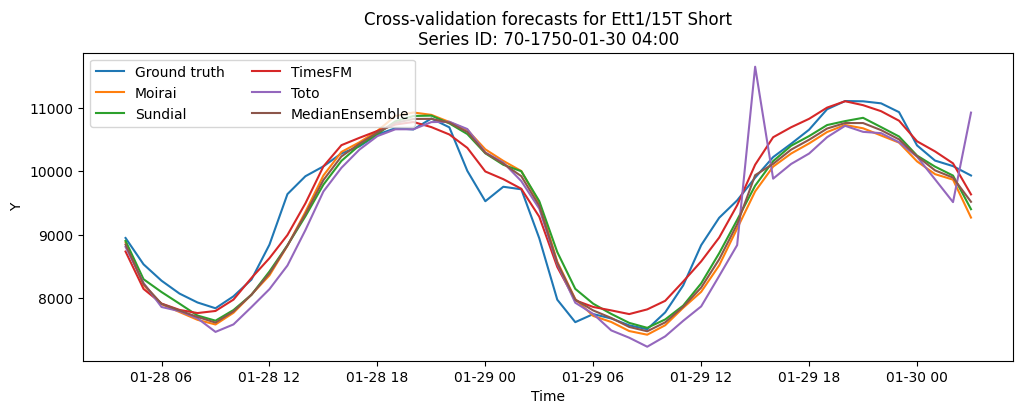

,Model,MAE,MSE,SMAPE
0,Moirai,39.851681,3028.425581,0.285539
1,Sundial,34.407503,2716.195956,0.241771
2,TimesFM,35.827713,2520.252404,0.318228
3,Toto,37.98877,3445.878098,0.269977
4,MedianEnsemble,34.076107,2585.07019,0.233406
5,Best Model,MedianEnsemble,TimesFM,MedianEnsemble


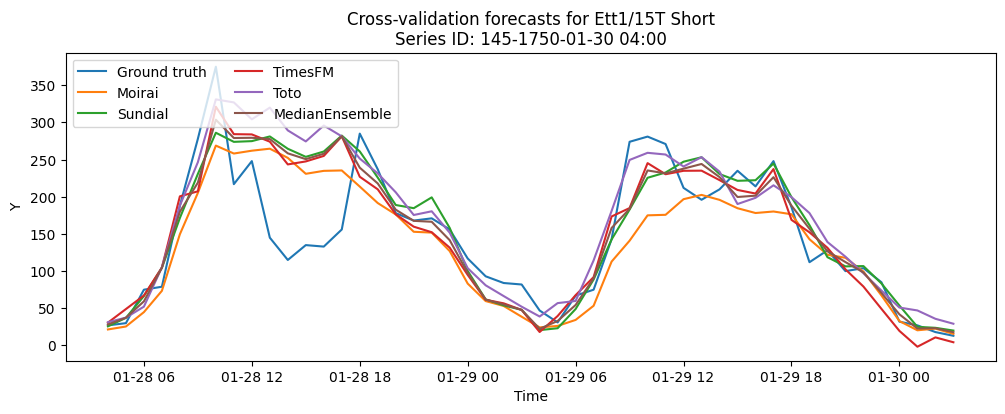

,Model,MAE,MSE,SMAPE
0,Moirai,96.274218,34979.633236,0.331027
1,Sundial,91.49539,31982.615014,0.307505
2,TimesFM,42.890465,9404.698643,0.195994
3,Toto,121.473225,70352.637702,0.410084
4,MedianEnsemble,84.671089,26972.004171,0.284451
5,Best Model,TimesFM,TimesFM,TimesFM


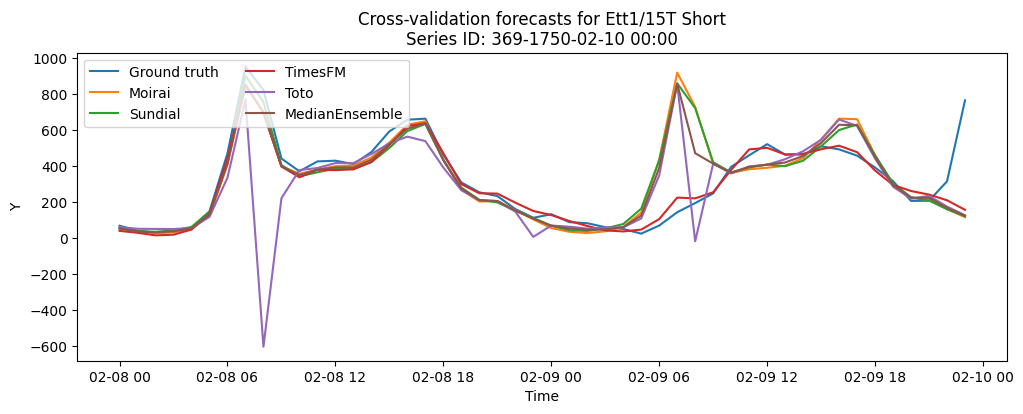

,Model,MAE,MSE,SMAPE
0,Moirai,97.708148,31807.237548,0.264893
1,Sundial,83.537194,30542.46355,0.207681
2,TimesFM,68.851462,16500.191736,0.291541
3,Toto,128.001575,72848.248435,0.400866
4,MedianEnsemble,77.338187,24166.79232,0.225465
5,Best Model,TimesFM,TimesFM,Sundial


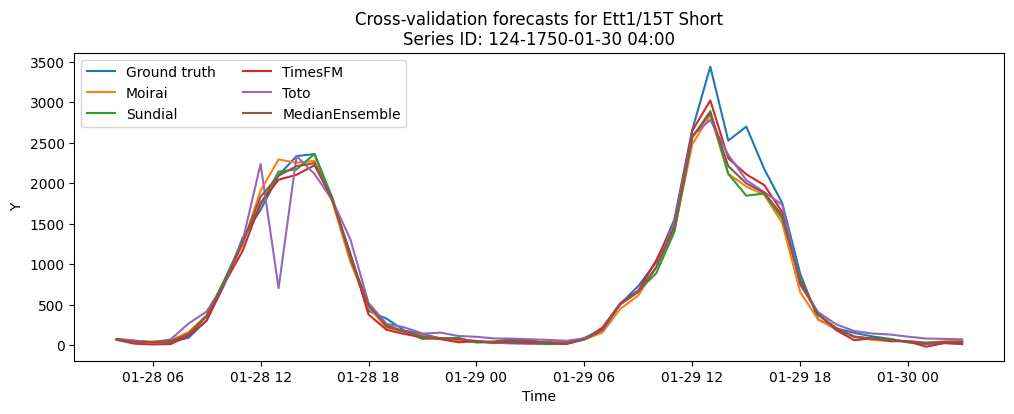

In [ ]:
random_state = 42
random_state = None
num_plots = 4

figsize = (12, 4)
xlabel = "Time"
ylabel = "Y"

models = [
    "Moirai",
    "Sundial",
    "TimesFM",
    "Toto",
    "MedianEnsemble",
]

random_ids = np.random.RandomState(random_state).choice(
    unique_ids,
    size=num_plots,
    replace=False,
)

for id in random_ids:
    series_df = df[df["unique_id"] == id]

    # Calculate metrics for this series
    series_metrics = []
    for model in models:
        mae_value = mean_absolute_error(series_df["y"], series_df[model])
        mse_value = mean_squared_error(series_df["y"], series_df[model])
        smape_value = smape(series_df["y"], series_df[model])

        series_metrics.append(
            {
                "Model": model,
                "MAE": mae_value,
                "MSE": mse_value,
                "SMAPE": smape_value,
            }
        )

    # Create metrics DataFrame
    metrics_df = pd.DataFrame(series_metrics)

    # Add row showing which model had the lowest metric in each column
    best_models = {
        "Model": "Best Model",
        "MAE": metrics_df.loc[metrics_df["MAE"].idxmin(), "Model"],
        "MSE": metrics_df.loc[metrics_df["MSE"].idxmin(), "Model"],
        "SMAPE": metrics_df.loc[metrics_df["SMAPE"].idxmin(), "Model"],
    }

    # Append the best models row
    metrics_df_with_best = pd.concat(
        [metrics_df, pd.DataFrame([best_models])], ignore_index=True
    )

    # Display metrics DataFrame with best models
    display(metrics_df_with_best.round(4))

    # Then display the plot
    plt.figure(figsize=figsize)
    plt.plot(series_df["ds"], series_df["y"], label="Ground truth")

    for model in models:
        plt.plot(series_df["ds"], series_df[model], label=model)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(
        f"Cross-validation Forecasts for {name.title()} {term.title()}\n"
        f"Series ID: {id}"
    )
    plt.legend(ncol=2, loc="upper left")
    plt.show()